In [1]:
import os
import string
from collections import Counter
from datetime import datetime

import nltk
import pandas as pd
import matplotlib
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.util import ngrams

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Preparing data

In [3]:
original_keywords = ["Picard", "Kirk", "Sulu", "Uhura", "Spock", "McCoy", "Bones", "Scotty", "Chekhov", "Crusher", "Nurse Chapel", "Sarek", "Nero", "Khan", "Data", "Pike", "Star Trek", "Klingon", "Vulcan", "Romulan", "Star fleet", "Starship Enterprise", "Delta Vega", "Earth", "Orion", "Romulan Narada", "Stardate", "Transporter beam", "Beam me up,\? Scotty", "Kobayashi Maru", "Space,\? The Final Frontier", "Energize", "Vulcan Salute", "Prime Directive", "Live long and prosper", "LLAP", "I'm a doctor,\? not a", "KHAAA\+N", "When you eliminate the impossible,\? whatever remains,\? however improbable,\? must be the truth", "Without followers,\? evil cannot spread", "The needs of the many outweigh the needs of the few", "Highly illogical", "to boldly go where no man has gone before", "I'm giving her all she's got,\? Captain", "Nuclear wessels", "Set phasers to stun", "Resistance is futile", "I have been and always shall be your friend"]

In [4]:
print(original_keywords)

['Picard', 'Kirk', 'Sulu', 'Uhura', 'Spock', 'McCoy', 'Bones', 'Scotty', 'Chekhov', 'Crusher', 'Nurse Chapel', 'Sarek', 'Nero', 'Khan', 'Data', 'Pike', 'Star Trek', 'Klingon', 'Vulcan', 'Romulan', 'Star fleet', 'Starship Enterprise', 'Delta Vega', 'Earth', 'Orion', 'Romulan Narada', 'Stardate', 'Transporter beam', 'Beam me up,\\? Scotty', 'Kobayashi Maru', 'Space,\\? The Final Frontier', 'Energize', 'Vulcan Salute', 'Prime Directive', 'Live long and prosper', 'LLAP', "I'm a doctor,\\? not a", 'KHAAA\\+N', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'The needs of the many outweigh the needs of the few', 'Highly illogical', 'to boldly go where no man has gone before', "I'm giving her all she's got,\\? Captain", 'Nuclear wessels', 'Set phasers to stun', 'Resistance is futile', 'I have been and always shall be your friend']


In [5]:
ambiguous_keywords = [
    'Bones',
    'Khan',
    'Data',
    'Earth',
    'Energize',
]

In [6]:
keywords = list(set(original_keywords).difference(ambiguous_keywords))
keywords = [w.replace('\\', '').lower() for w in keywords]
keywords.sort()

In [7]:
print(keywords)

['beam me up,? scotty', 'chekhov', 'crusher', 'delta vega', 'highly illogical', 'i have been and always shall be your friend', "i'm a doctor,? not a", "i'm giving her all she's got,? captain", 'khaaa+n', 'kirk', 'klingon', 'kobayashi maru', 'live long and prosper', 'llap', 'mccoy', 'nero', 'nuclear wessels', 'nurse chapel', 'orion', 'picard', 'pike', 'prime directive', 'resistance is futile', 'romulan', 'romulan narada', 'sarek', 'scotty', 'set phasers to stun', 'space,? the final frontier', 'spock', 'star fleet', 'star trek', 'stardate', 'starship enterprise', 'sulu', 'the needs of the many outweigh the needs of the few', 'to boldly go where no man has gone before', 'transporter beam', 'uhura', 'vulcan', 'vulcan salute', 'when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth', 'without followers,? evil cannot spread']


In [8]:
%%time

dtypes = {
    'author': str,
    'body': str,
    'controversiality': str,
    'created_utc': pd.tslib.Timestamp,
    'distinguished': str,
    'downs': str,
    'gilded': str,
    'id': str,
    'name': str,
    'parent_id': str,
    'score': str,
    'subreddit': str,
    'ups': str,
    'month': pd.tslib.Timestamp,
    'year': pd.tslib.Timestamp,
}

reddit_df = pd.read_csv('reddit.csv', header=0, dtype=dtypes, parse_dates=['created_utc', 'month', 'year'])
reddit_df = reddit_df.fillna('')

CPU times: user 35.1 s, sys: 2.2 s, total: 37.3 s
Wall time: 52.5 s


In [9]:
len(reddit_df)

2669814

In [10]:
reddit_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
0,gschizas,same in greek. my personal peeve: quite a lot ...,0,2007-10-15 15:22:33,,0.0,0,c029c79,t1_c029c79,t1_c029brz,13,programming,13,2007-10-01,2007-01-01
1,[deleted],&gt;they also decided to rig a thermal barrier...,0,2007-10-16 05:11:09,,0.0,0,c029g6h,t1_c029g6h,t3_5ye94,2,programming,2,2007-10-01,2007-01-01
2,johnmudd,&gt; by the time a child born today graduates ...,0,2007-10-16 07:00:36,,0.0,0,c029gfc,t1_c029gfc,t3_5ye9w,1,science,1,2007-10-01,2007-01-01
3,feliniti,nero 8 - bloated waste of money. unless you ha...,0,2007-10-16 07:10:27,,0.0,0,c029gge,t1_c029gge,t3_5yej4,1,reddit.com,1,2007-10-01,2007-01-01
4,masklinn,&gt; i wonder what happens if you started clea...,0,2007-10-16 11:27:15,,0.0,0,c029hiy,t1_c029hiy,t1_c029h3y,3,reddit.com,3,2007-10-01,2007-01-01


# Analyzing data

## Subreddits

In [11]:
reddit_df['subreddit'].nunique()

24076

In [12]:
reddit_df['subreddit'].value_counts()

AdviceAnimals           216848
startrek                182534
AskReddit               179550
fantasyfootball          92045
movies                   65545
nfl                      62410
Smite                    58973
DaystromInstitute        57314
sto                      44103
funny                    37788
doctorwho                35282
pics                     35054
scifi                    33434
Planetside               27387
todayilearned            25934
GlobalOffensiveTrade     25360
motorcycles              24585
SquaredCircle            20231
Civcraft                 19555
IAmA                     18502
gaming                   18339
atheism                  18110
grandorder               16730
chicagobulls             16501
videos                   16271
nba                      16193
PercyJacksonRP           15635
CFB                      15368
WTF                      13752
TheDescendantsOfRome     13213
                         ...  
rescuecats                   1
Critique

## Global variables

In [13]:
valid_dates = pd.date_range('2007-10-1', '2016-08-31', freq='MS')

In [14]:
P = 10

## AskReddit

In [15]:
subreddit = 'AskReddit'

peaks = ['2008-02-01', '2009-05-01', '2010-01-01', '2012-07-01', '2013-06-01',]
peaks = list(map(pd.lib.Timestamp, peaks))

title = 'Number of comments on subreddit \'' + subreddit + '\' by month'

In [16]:
%%time

subreddit_df = reddit_df[reddit_df['subreddit'] == subreddit]

CPU times: user 380 ms, sys: 100 ms, total: 480 ms
Wall time: 601 ms


In [17]:
len(subreddit_df)

179550

In [18]:
subreddit_by_month = pd.Series(subreddit_df.groupby('month')['id'].count())
subreddit_by_month.index.name = None

In [19]:
show_dates = [x.strftime('%Y %b') if x in peaks else '' for x in valid_dates]

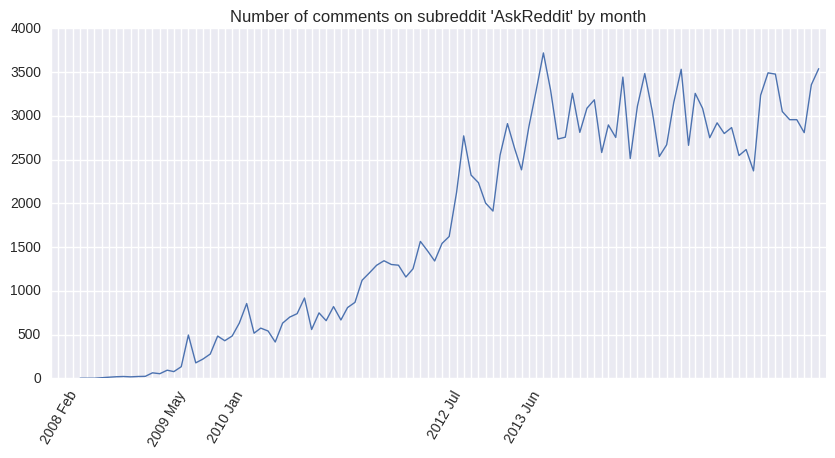

In [20]:
ax = subreddit_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=valid_dates,
    rot=60,
    title=title,
)
ax.set_xticklabels(show_dates);

### Peaks

In [21]:
peaks

[Timestamp('2008-02-01 00:00:00'),
 Timestamp('2009-05-01 00:00:00'),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2012-07-01 00:00:00'),
 Timestamp('2013-06-01 00:00:00')]

#### 2009-05-01

In [22]:
date = '2009-05-01'

In [23]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [24]:
len(subreddit_date_df)

495

#### Histogram

###### Keywords

In [25]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = subreddit_date_df[subreddit_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [26]:
keywords_counter = Counter(keywords_dict)

In [27]:
keywords_counter.most_common()

[('star trek', 304),
 ('kirk', 132),
 ('spock', 125),
 ('vulcan', 73),
 ('picard', 46),
 ('romulan', 31),
 ('nero', 29),
 ('klingon', 20),
 ('pike', 19),
 ('scotty', 17),
 ('orion', 16),
 ('uhura', 14),
 ('mccoy', 12),
 ('sulu', 12),
 ('khaaa+n', 7),
 ('kobayashi maru', 6),
 ('resistance is futile', 4),
 ('prime directive', 3),
 ('highly illogical', 3),
 ('sarek', 2),
 ('llap', 2),
 ('star fleet', 2),
 ('the needs of the many outweigh the needs of the few', 1),
 ('nuclear wessels', 1),
 ('chekhov', 1),
 ('live long and prosper', 1),
 ('stardate', 1),
 ('when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth',
  0),
 ("i'm a doctor,? not a", 0),
 ('i have been and always shall be your friend', 0),
 ('crusher', 0),
 ('beam me up,? scotty', 0),
 ('vulcan salute', 0),
 ('set phasers to stun', 0),
 ('to boldly go where no man has gone before', 0),
 ("i'm giving her all she's got,? captain", 0),
 ('delta vega', 0),
 ('nurse chapel', 0),
 ('starship ente

In [28]:
keywords_sr = pd.Series(keywords_dict)

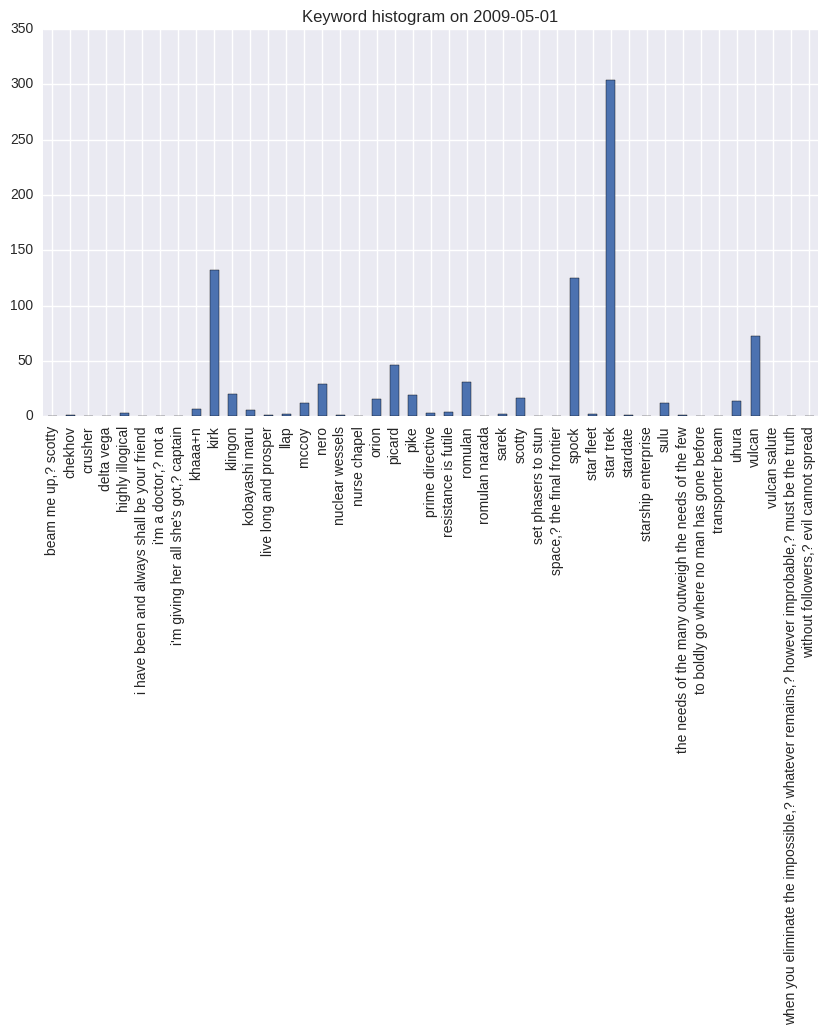

In [29]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [30]:
%%time

text_ = ''
for x in subreddit_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 5.26 s, sys: 328 ms, total: 5.59 s
Wall time: 5.88 s


In [31]:
counter_.most_common(20)

[('star', 319),
 ('trek', 319),
 ("'s", 305),
 ("n't", 215),
 ('movie', 167),
 ("''", 152),
 ('like', 152),
 ('``', 152),
 ('would', 145),
 ('time', 121),
 ('kirk', 120),
 ('spock', 113),
 ('one', 112),
 ('...', 110),
 ("'m", 91),
 ('really', 90),
 ('good', 86),
 ('first', 86),
 ('people', 80),
 ('see', 77)]

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [32]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 464 ms, sys: 0 ns, total: 464 ms
Wall time: 564 ms


In [33]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [34]:
sentiment_df.head()

,body,sentiment,subjectivity
0,"the 8th is also opening day for star trek, kin...",0.60,0.90
1,"1. put on a birthday hat, go to a coffee shop,...",0.22,0.60
2,"i throw the ""live long and prosper"" sign all t...",0.04,0.45
3,i'm deuteranoptic myself. so i absolutely don...,0.03,0.37
4,try for a nice vulcan lass then,0.60,1.00


In [35]:
sentiment_df['sentiment'].mean()

0.11422600837005575

In [36]:
sentiment_df['subjectivity'].mean()

0.41543679432474867

##### Histogram top positive

In [37]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [38]:
top_df

,body,sentiment,subjectivity
69,simon pegg as scotty was perfect.,1.00,1.00
426,"tng is the best. worf, data, picard. best star...",1.00,0.30
412,check out pike's peak. it's awesome!!,1.00,1.00
117,because i went to see the 10.00 am screening o...,1.00,0.30
139,"""i saw star trek yesterday in oslo norway. tha...",0.82,0.88
306,"depends is kirk, pecard, or kirk-b captaining?...",0.80,0.40
135,easily the best star trek movie ever made.,0.72,0.57
272,star trek iv is probably the best introduction...,0.69,0.53
10,&gt; * make people sing the happy birthday son...,0.69,0.87
247,"amazingly, my dvds of pre-abrams star trek sti...",0.60,0.90


In [39]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 340 ms, sys: 12 ms, total: 352 ms
Wall time: 350 ms


In [40]:
top_counter = Counter(top_list)

In [41]:
top_counter.most_common(20)

[('star', 38),
 ('trek', 34),
 ("'s", 23),
 ("n't", 13),
 ('good', 12),
 ('movie', 12),
 ('http', 12),
 ('make', 11),
 ('gt', 10),
 ('would', 10),
 ('like', 9),
 ('best', 9),
 ('great', 9),
 ('people', 9),
 ('one', 8),
 ('happy', 7),
 ('awesome', 7),
 ('kirk', 7),
 ('song', 7),
 ('also', 7)]

##### Histogram top negative

In [42]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [43]:
top_df

,body,sentiment,subjectivity
372,warp drive is the worst thing to happen to sta...,-1.00,1.00
348,"i can curl my tongue, wiggle ears, do vulcan v...",-0.75,1.00
398,"haha, reminds me of phillip seymour hoffman's ...",-0.70,0.68
87,was anyone else shocked to see winona ryder's ...,-0.70,0.80
414,fucking star trek,-0.60,0.80
294,i'd make it in to a cutting edge sci fi starri...,-0.60,0.90
112,star trek was missing ugly ewoks.,-0.45,0.53
467,"i grew up watching kirk, he had a way with the...",-0.40,0.60
466,"fuck kirk, picard is the man, you can just out...",-0.40,0.60
104,1. nimoy - - - - 2. how the fuck can you no...,-0.40,0.60


In [44]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 336 ms, sys: 16 ms, total: 352 ms
Wall time: 351 ms


In [45]:
top_counter = Counter(top_list)

In [46]:
top_counter.most_common(20)

[('trek', 28),
 ('star', 26),
 ("''", 14),
 ('``', 14),
 ("'s", 14),
 ('would', 10),
 ('kirk', 10),
 ('one', 8),
 ('movie', 8),
 ("'m", 8),
 ('episode', 8),
 ("n't", 7),
 ('spock', 7),
 ('like', 6),
 ('fucking', 6),
 ('picard', 6),
 ('captain', 5),
 ('red', 5),
 ('vulcan', 5),
 ('everyone', 5)]

In [47]:
peaks

[Timestamp('2008-02-01 00:00:00'),
 Timestamp('2009-05-01 00:00:00'),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2012-07-01 00:00:00'),
 Timestamp('2013-06-01 00:00:00')]

#### 2010-01-01

In [48]:
date = '2010-01-01'

In [49]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [50]:
len(subreddit_date_df)

855

#### Histogram

###### Keywords

In [51]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = subreddit_date_df[subreddit_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [52]:
keywords_counter = Counter(keywords_dict)

In [53]:
keywords_counter.most_common()

[('star trek', 561),
 ('spock', 123),
 ('kirk', 107),
 ('picard', 93),
 ('vulcan', 52),
 ('nero', 52),
 ('klingon', 39),
 ('crusher', 30),
 ('pike', 25),
 ('orion', 24),
 ('romulan', 20),
 ('scotty', 18),
 ('mccoy', 17),
 ('live long and prosper', 10),
 ('prime directive', 9),
 ('resistance is futile', 6),
 ('star fleet', 5),
 ('uhura', 4),
 ('khaaa+n', 4),
 ('sulu', 4),
 ('starship enterprise', 4),
 ('kobayashi maru', 3),
 ('chekhov', 3),
 ('llap', 3),
 ('stardate', 2),
 ('nuclear wessels', 1),
 ("i'm a doctor,? not a", 1),
 ('vulcan salute', 1),
 ('to boldly go where no man has gone before', 1),
 ('delta vega', 1),
 ('highly illogical', 1),
 ('space,? the final frontier', 1),
 ('transporter beam', 1),
 ('the needs of the many outweigh the needs of the few', 0),
 ('when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth',
  0),
 ('sarek', 0),
 ('i have been and always shall be your friend', 0),
 ('beam me up,? scotty', 0),
 ('set phasers to stun',

In [54]:
keywords_sr = pd.Series(keywords_dict)

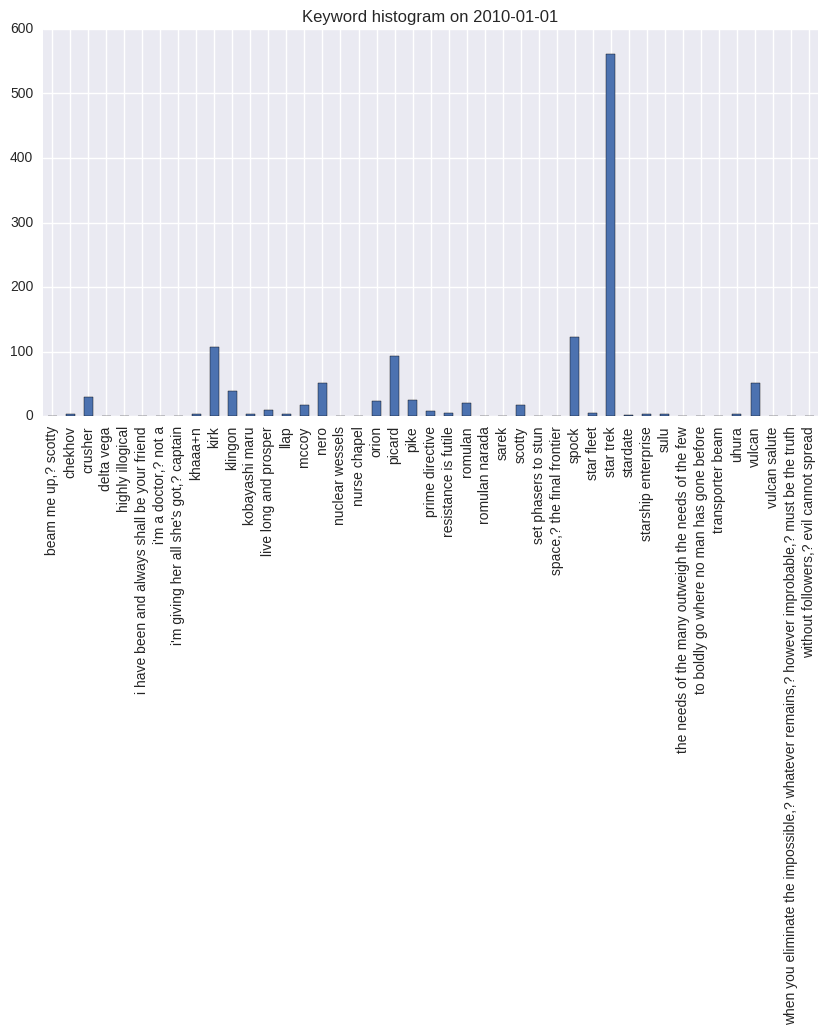

In [55]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [56]:
%%time

text_ = ''
for x in subreddit_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 9 s, sys: 564 ms, total: 9.56 s
Wall time: 9.56 s


In [57]:
counter_.most_common(20)

[('star', 741),
 ('trek', 565),
 ("'s", 492),
 ("n't", 379),
 ('like', 256),
 ("''", 254),
 ('``', 253),
 ('would', 232),
 ('...', 184),
 ('one', 171),
 ('wars', 169),
 ('http', 150),
 ('time', 142),
 ('could', 138),
 ('get', 137),
 ('think', 131),
 ('spock', 119),
 ("'m", 118),
 ('people', 104),
 ('really', 100)]

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [58]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 588 ms, sys: 4 ms, total: 592 ms
Wall time: 587 ms


In [59]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [60]:
sentiment_df.head()

,body,sentiment,subjectivity
0,i was 21 and working two jobs to get by while ...,-0.04,0.44
1,photosynthesis. if people could stand in the ...,0.11,0.71
2,it's great! think of it like chekhov while yo...,0.42,0.57
3,"oh, spock, you take the romance out of everyth...",0.00,0.00
4,star trek marathon with my man.,0.00,0.00


In [61]:
sentiment_df['sentiment'].mean()

0.083730068174755978

In [62]:
sentiment_df['subjectivity'].mean()

0.40900448151424623

##### Histogram top positive

In [63]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [64]:
top_df

,body,sentiment,subjectivity
670,&gt;the best diplomat i know is a fully charge...,1.00,0.30
836,i was named after a star trek character. - - ...,1.00,1.00
469,i had never seen any of the star trek movies o...,1.00,1.00
700,kinda looks like a perfect split between tasha...,0.88,1.00
752,also colt mccoy use to mow my great grandmothe...,0.80,0.75
840,hopefully tomorrow i'll win a $500 gift certif...,0.80,0.40
149,"you know, that just isn't the case with some s...",0.80,0.50
444,"yes. see a play; watch a film. better yet, see...",0.75,0.75
300,good call with picard. i like it.,0.70,0.60
261,"""all good things.."" when captain picard create...",0.70,0.60


In [65]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 468 ms, sys: 28 ms, total: 496 ms
Wall time: 493 ms


In [66]:
top_counter = Counter(top_list)

In [67]:
top_counter.most_common(20)

[('star', 60),
 ('trek', 51),
 ("'s", 23),
 ("n't", 22),
 ('would', 17),
 ('good', 16),
 ('like', 16),
 ('``', 14),
 ("''", 14),
 ('http', 13),
 ('one', 13),
 ('wars', 11),
 ('kirk', 11),
 ('better', 11),
 ('also', 10),
 ('think', 10),
 ('could', 9),
 ('awesome', 8),
 ('picard', 8),
 ('**', 8)]

##### Histogram top negative

In [68]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [69]:
top_df

,body,sentiment,subjectivity
732,"star trek, star wars, battle star (never seen ...",-1.00,1.00
388,-[phoenix wright's ringtone](http://www.youtub...,-0.94,0.95
308,philosophy and introductory mathematics (retar...,-0.90,1.00
157,ds9 was a soap set in a star trek universe. aw...,-0.88,1.00
682,"uh, can people who hate ""star trek"" leave?",-0.80,0.90
524,and you could play luke and have sex with leia...,-0.78,1.00
151,saw the girl that played georgia at a star tre...,-0.70,0.67
599,ensign ro is not only the worst character in s...,-0.67,1.00
663,"time travel, in star trek? i find that unlikely!",-0.62,0.50
648,*star trek- solving problems using fucking bad...,-0.60,0.80


In [70]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 540 ms, sys: 24 ms, total: 564 ms
Wall time: 563 ms


In [71]:
top_counter = Counter(top_list)

In [72]:
top_counter.most_common(20)

[('star', 55),
 ('trek', 49),
 ("n't", 34),
 ("'s", 31),
 ('like', 22),
 ("''", 13),
 ('would', 13),
 ('...', 13),
 ('kirk', 12),
 ('spock', 11),
 ('http', 11),
 ('``', 11),
 ('could', 10),
 ('one', 10),
 ('bad', 10),
 ('think', 9),
 ('movie', 9),
 ('wars', 8),
 ('get', 8),
 ('way', 8)]

In [73]:
peaks

[Timestamp('2008-02-01 00:00:00'),
 Timestamp('2009-05-01 00:00:00'),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2012-07-01 00:00:00'),
 Timestamp('2013-06-01 00:00:00')]

#### 2012-07-01

In [74]:
date = '2012-07-01'

In [75]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [76]:
len(subreddit_date_df)

2771

#### Histogram

###### Keywords

In [77]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = subreddit_date_df[subreddit_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [78]:
keywords_counter = Counter(keywords_dict)

In [79]:
keywords_counter.most_common()

[('star trek', 994),
 ('resistance is futile', 674),
 ('picard', 280),
 ('kirk', 207),
 ('spock', 191),
 ('pike', 104),
 ('vulcan', 94),
 ('orion', 94),
 ('nero', 91),
 ('scotty', 90),
 ('klingon', 89),
 ('crusher', 72),
 ('mccoy', 38),
 ('uhura', 35),
 ('live long and prosper', 32),
 ('prime directive', 19),
 ('starship enterprise', 18),
 ('romulan', 16),
 ('khaaa+n', 13),
 ("i'm a doctor,? not a", 12),
 ('beam me up,? scotty', 12),
 ('chekhov', 10),
 ('star fleet', 9),
 ('kobayashi maru', 8),
 ('sulu', 8),
 ('vulcan salute', 6),
 ('the needs of the many outweigh the needs of the few', 5),
 ('nuclear wessels', 4),
 ('to boldly go where no man has gone before', 4),
 ('highly illogical', 4),
 ('llap', 4),
 ('set phasers to stun', 2),
 ('nurse chapel', 2),
 ('stardate', 2),
 ('i have been and always shall be your friend', 1),
 ('delta vega', 1),
 ('when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth',
  0),
 ('sarek', 0),
 ("i'm giving her all sh

In [80]:
keywords_sr = pd.Series(keywords_dict)

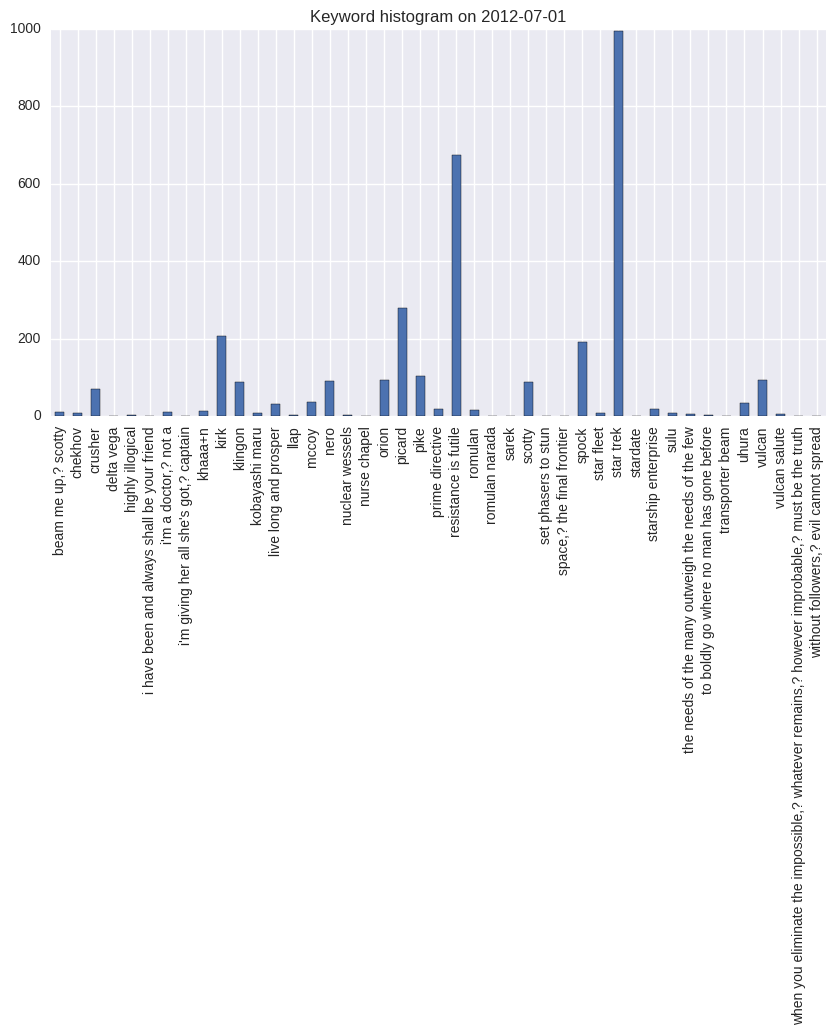

In [81]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [82]:
%%time

text_ = ''
for x in subreddit_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 18.6 s, sys: 1.15 s, total: 19.8 s
Wall time: 19.8 s


In [83]:
counter_.most_common(20)

[('star', 1085),
 ('trek', 981),
 ("'s", 932),
 ("n't", 865),
 ("''", 691),
 ('resistance', 674),
 ('futile', 674),
 ('borg', 671),
 ('``', 658),
 ('assimilated', 652),
 ('like', 538),
 ('would', 455),
 ('...', 436),
 ('one', 360),
 ("'m", 288),
 ('time', 283),
 ('http', 271),
 ('get', 265),
 ('people', 254),
 ('picard', 253)]

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [84]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 1.19 s, sys: 8 ms, total: 1.2 s
Wall time: 1.2 s


In [85]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [86]:
sentiment_df.head()

,body,sentiment,subjectivity
0,scotty doesn't know!,0.00,0.00
1,[this says it all](http://picardfacepalm.com/p...,0.00,0.00
2,"star trek ii, wrath of khan, when spock dies. ...",0.40,0.75
3,nero's welcome reality album... its so amazing,0.70,0.90
4,picard is better than kirk.,0.50,0.50


In [87]:
sentiment_df['sentiment'].mean()

0.056686583318592935

In [88]:
sentiment_df['subjectivity'].mean()

0.28898559804792173

##### Histogram top positive

In [89]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [90]:
top_df

,body,sentiment,subjectivity
218,"captain! jean luc piccard! - btw, best ytmnd l...",1.00,0.30
258,his crew would also make an awesome cabinet - ...,1.00,1.00
1747,it looks like a copycat of [kinoko no yama](ht...,1.00,1.00
1948,i'd prefer romulan. by science did they have i...,1.00,1.00
2014,star trek: voyager. the theme song is exquisite.,1.00,1.00
134,i don't think so. we're just playing thought g...,1.00,1.00
1749,kirk is the best. suck on it.,1.00,0.30
434,"star trek tng: the best of both worlds - - ""i...",1.00,0.30
45,i'm streaming star trek voyager on tv. i think...,1.00,1.00
6,"spawn...marilyn manson, kirk hammett, just alo...",1.00,1.00


In [91]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 1.5 s, sys: 108 ms, total: 1.6 s
Wall time: 1.6 s


In [92]:
top_counter = Counter(top_list)

In [93]:
top_counter.most_common(20)

[('star', 151),
 ('trek', 136),
 ("'s", 80),
 ("n't", 65),
 ('would', 49),
 ("''", 46),
 ('``', 44),
 ('like', 41),
 ('good', 39),
 ('best', 38),
 ("'m", 37),
 ('love', 36),
 ('picard', 35),
 ('...', 34),
 ('kirk', 33),
 ('http', 31),
 ('also', 28),
 ('time', 27),
 ('spock', 24),
 ('tng', 24)]

##### Histogram top negative

In [94]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [95]:
top_df

,body,sentiment,subjectivity
1838,[duck sauce - barbara streisand](http://www.yo...,-1.00,1.00
213,omfg that is bs wtf?!?!?! kirk would beat up p...,-1.00,1.00
850,"if star trek has taught me anything, it's that...",-1.00,1.00
368,they did a star trek deepspace nine episode li...,-0.90,0.70
726,"what he said is 100% correct, if you aren't th...",-0.90,1.00
2037,"i hate to tell you this, but spock dies in the...",-0.80,0.90
257,the idealistic picard from the television seri...,-0.80,1.00
1754,spock? from that stupid star trek movie where ...,-0.80,1.00
2033,yup: [uhura's song](http://www.youtube.com/wat...,-0.75,1.00
1454,o no! =( set phasers to stun,-0.75,1.00


In [96]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 2.06 s, sys: 128 ms, total: 2.19 s
Wall time: 2.19 s


In [97]:
top_counter = Counter(top_list)

In [98]:
top_counter.most_common(20)

[('star', 137),
 ("'s", 127),
 ("n't", 123),
 ('trek', 123),
 ('``', 96),
 ("''", 94),
 ('...', 70),
 ('like', 67),
 ('fuck', 49),
 ("'m", 48),
 ('would', 47),
 ('get', 35),
 ('picard', 34),
 ('one', 33),
 ('people', 30),
 ('http', 30),
 ('shit', 28),
 ('time', 27),
 ('kirk', 26),
 ('also', 26)]

In [99]:
peaks

[Timestamp('2008-02-01 00:00:00'),
 Timestamp('2009-05-01 00:00:00'),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2012-07-01 00:00:00'),
 Timestamp('2013-06-01 00:00:00')]

#### 2013-06-01

In [100]:
date = '2013-06-01'

In [101]:
subreddit_date_df = subreddit_df[subreddit_df['month'] == date]

In [102]:
len(subreddit_date_df)

3719

#### Histogram

###### Keywords

In [103]:
keywords_dict = {}
for keyword in keywords:
    keyword_df = subreddit_date_df[subreddit_date_df['body'].str.contains(keyword)]
    count = keyword_df['body'].str.count(keyword).sum()
    keywords_dict[keyword] = count

In [104]:
keywords_counter = Counter(keywords_dict)

In [105]:
keywords_counter.most_common()

[('star trek', 2191),
 ('kirk', 544),
 ('spock', 423),
 ('picard', 243),
 ('scotty', 189),
 ('orion', 185),
 ('vulcan', 168),
 ('klingon', 159),
 ('pike', 133),
 ('crusher', 127),
 ('nero', 124),
 ('prime directive', 88),
 ('mccoy', 70),
 ('romulan', 65),
 ('khaaa+n', 48),
 ('sulu', 36),
 ('resistance is futile', 33),
 ('starship enterprise', 28),
 ('star fleet', 22),
 ('uhura', 20),
 ('live long and prosper', 17),
 ("i'm a doctor,? not a", 11),
 ('kobayashi maru', 10),
 ('llap', 10),
 ('chekhov', 8),
 ('vulcan salute', 8),
 ('beam me up,? scotty', 7),
 ('the needs of the many outweigh the needs of the few', 6),
 ('nuclear wessels', 6),
 ('highly illogical', 5),
 ('to boldly go where no man has gone before', 4),
 ('stardate', 4),
 ('sarek', 3),
 ("i'm giving her all she's got,? captain", 3),
 ('delta vega', 2),
 ('transporter beam', 2),
 ('i have been and always shall be your friend', 1),
 ('set phasers to stun', 1),
 ('space,? the final frontier', 1),
 ('when you eliminate the impossi

In [106]:
keywords_sr = pd.Series(keywords_dict)

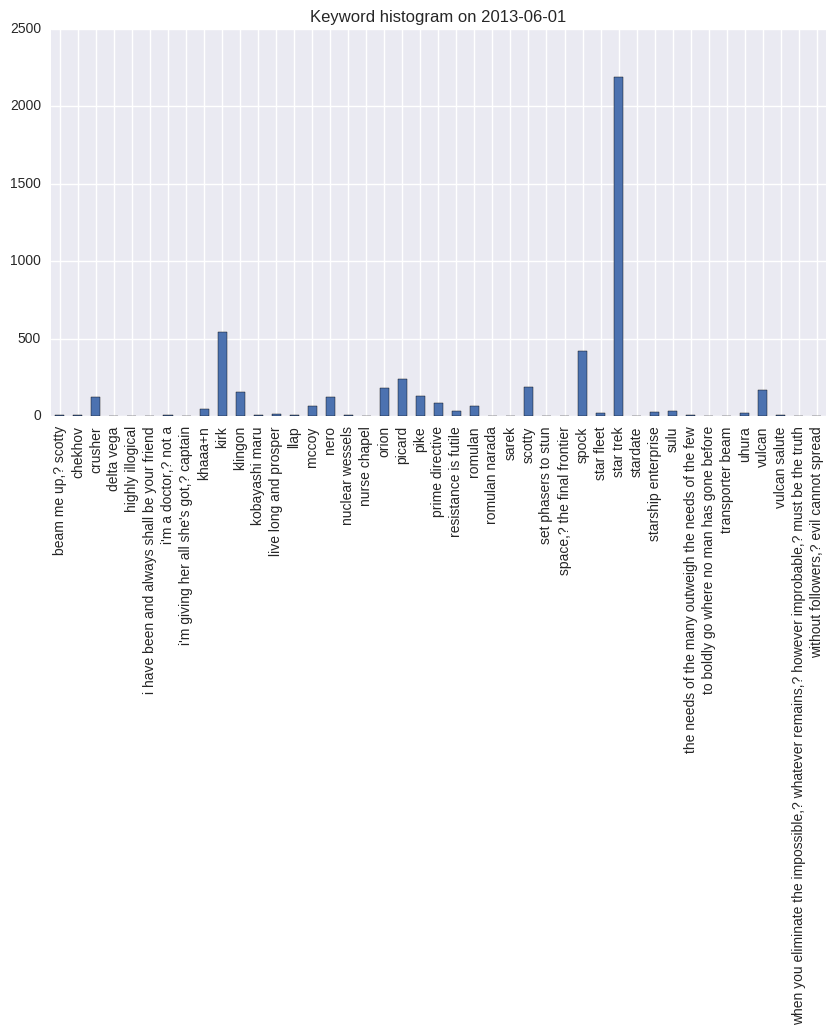

In [107]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Keyword histogram on ' + date,
)

###### Other words

In [108]:
%%time

text_ = ''
for x in subreddit_date_df['body']:
    text_ += x + ' '

list_ = [
    w
    for w in nltk.word_tokenize(text_)
    if w not in stopwords.words('english') and w not in string.punctuation
]

counter_ = Counter(list_)

CPU times: user 28.6 s, sys: 1.8 s, total: 30.4 s
Wall time: 30.4 s


In [109]:
counter_.most_common(20)

[('star', 2326),
 ('trek', 2181),
 ("'s", 1642),
 ("n't", 1383),
 ('``', 967),
 ("''", 951),
 ('like', 864),
 ('...', 820),
 ('would', 751),
 ('one', 675),
 ('kirk', 513),
 ('time', 504),
 ('people', 499),
 ('spock', 397),
 ("'m", 389),
 ('get', 387),
 ('movie', 379),
 ('really', 370),
 ('also', 367),
 ('think', 347)]

#### Sentiment analysis

- The polarity score is a float within the range [-1.0, 1.0].
- The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [110]:
%%time

sentiment_list = []
for x in subreddit_date_df['body']:
    tb = TextBlob(x)
    sentiment_list.append((x, tb.sentiment.polarity, tb.sentiment.subjectivity))

CPU times: user 1.77 s, sys: 0 ns, total: 1.77 s
Wall time: 1.77 s


In [111]:
sentiment_df = pd.DataFrame(sentiment_list, columns=['body', 'sentiment', 'subjectivity'])

In [112]:
sentiment_df.head()

,body,sentiment,subjectivity
0,mike verta...winnie coppers husband in real li...,0.20,0.30
1,"that one woman calling another a ""fucking cunt...",-0.38,0.50
2,"* ""come for the low prices, stay for the peopl...",0.05,0.62
3,any star trek movie. oh my i just saw the new ...,0.07,0.40
4,star trek into darkness. that was an emotional...,0.00,0.65


In [113]:
sentiment_df['sentiment'].mean()

0.071882055447587231

In [114]:
sentiment_df['subjectivity'].mean()

0.37258776624856049

##### Histogram top positive

In [115]:
top_df = sentiment_df.sort_values('sentiment', ascending=False)[:len(subreddit_date_df) * P // 100]

In [116]:
top_df

,body,sentiment,subjectivity
969,best part is when you whip out a klingon war b...,1.00,0.30
3181,orion by metallica. - - cliff at his very best.,1.00,0.39
2744,spock would be my best friend. archenemy would...,1.00,0.30
1246,aaaaaaaaannnd... this is why we're best friend...,1.00,0.30
750,"transporter room 3. if your a trekkie, it's t...",1.00,0.30
38,who's the hottest in this awesome star trek fr...,1.00,1.00
2838,goldsmith's star trek: the motion picture scor...,1.00,1.00
827,star trek. i have to say it's one of the best ...,1.00,0.30
243,the food replicator from star trek would be so...,1.00,1.00
569,"star trek into darkness. great movie, but they...",1.00,0.75


In [117]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 1.66 s, sys: 84 ms, total: 1.74 s
Wall time: 1.74 s


In [118]:
top_counter = Counter(top_list)

In [119]:
top_counter.most_common(20)

[('star', 261),
 ('trek', 243),
 ("'s", 114),
 ("''", 85),
 ('``', 79),
 ('best', 61),
 ("n't", 56),
 ('one', 47),
 ('like', 46),
 ('great', 41),
 ('would', 40),
 ('kirk', 38),
 ('good', 36),
 ('original', 36),
 ('awesome', 31),
 ('movie', 30),
 ('series', 30),
 ('better', 28),
 ("'m", 27),
 ('love', 26)]

##### Histogram top negative

In [120]:
top_df = sentiment_df.sort_values('sentiment', ascending=True)[:len(subreddit_date_df) * P // 100]

In [121]:
top_df

,body,sentiment,subjectivity
829,kahn was evil - - the matters weren't civil -...,-1.00,1.00
2725,when i decided to take the mass pike home from...,-1.00,1.00
2576,so you'd have a 99.9% chance of being a muggle...,-1.00,1.00
3448,"kes, star trek: voyager. worst mary sue.....e...",-1.00,1.00
2803,star trek enterprise...that song is the worst.,-1.00,1.00
2536,star trek: voyager or enterprise. both were aw...,-1.00,1.00
362,dr. evil would probably try project vulcan again,-1.00,1.00
2987,wesley crusher. - - just... just awful.,-1.00,1.00
2596,zoe saldana was so fucking terrible in the new...,-1.00,1.00
3403,damn that's some terrible parenting,-1.00,1.00


In [122]:
%%time

top_text = ''
for x in top_df['body']:
    top_text += x + ' '

top_list = [
    w
    for w in nltk.word_tokenize(top_text)
    if w not in stopwords.words('english') and w not in string.punctuation
]

CPU times: user 2.07 s, sys: 68 ms, total: 2.14 s
Wall time: 2.14 s


In [123]:
top_counter = Counter(top_list)

In [124]:
top_counter.most_common(20)

[('star', 223),
 ('trek', 213),
 ("'s", 125),
 ("n't", 115),
 ('``', 84),
 ("''", 79),
 ('like', 69),
 ('one', 60),
 ('would', 56),
 ('also', 45),
 ('kirk', 41),
 ('...', 40),
 ('http', 40),
 ('fucking', 39),
 ('spock', 36),
 ('take', 34),
 ("'m", 33),
 ('get', 32),
 ('people', 31),
 ('fuck', 30)]